##### Copyright 2019 The TensorFlow Authors.

In [2]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Image classification with TensorFlow Lite Model Maker

Model Maker library simplifies the process of adapting and converting a TensorFlow neural-network model to particular input data when deploying this model for on-device ML applications.

This notebook shows an end-to-end example that utilizes this Model Maker library to illustrate the adaption and conversion of a commonly-used image classification model to classify mask or no mask on a mobile device.

## Prerequisites

To run this example, we first need to install several required packages, including Model Maker package that in GitHub [repo](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker).

Here we already installed pre requisite libraries. It contains
##tensorflow 2.7,python 3.9, tflite model maker, matplotlib,openCV an pillow libraries##

##import necessary libraries##

In [3]:
import os

import numpy as np

import tensorflow as tf
assert tf.__version__.startswith('2')

from tflite_model_maker import model_spec
from tflite_model_maker import image_classifier
from tflite_model_maker.config import ExportFormat
from tflite_model_maker.config import QuantizationConfig
from tflite_model_maker.image_classifier import DataLoader

import matplotlib.pyplot as plt

In [4]:
#set the image folder for training and test
# image_path='/Users/zobaid/Documents/scrap/train'
image_path = "/Users/zobaid/Documents/scrap/dataset/train/"
image_path2 = "/Users/zobaid/Documents/scrap/dataset/test/"

If you prefer not to upload your images to the cloud, you could try to run the library locally following the [guide](https://github.com/tensorflow/examples/tree/master/tensorflow_examples/lite/model_maker) in GitHub.

### Run the code



Step 1.   Load input data specific to an on-device ML app. Split it to training data and testing data.

In [5]:
data = DataLoader.from_folder(image_path)
data2 = DataLoader.from_folder(image_path2)

# train_data, test_data = data.split(0.85)


INFO:tensorflow:Load image with size: 2670, num_label: 2, labels: mask, no-mask.
INFO:tensorflow:Load image with size: 194, num_label: 2, labels: mask, no-mask.


In [6]:
#split the folder into train,validation,test
train_data, rest_data = data.split(0.8)
validation_data, test_data = rest_data.split(0.5)

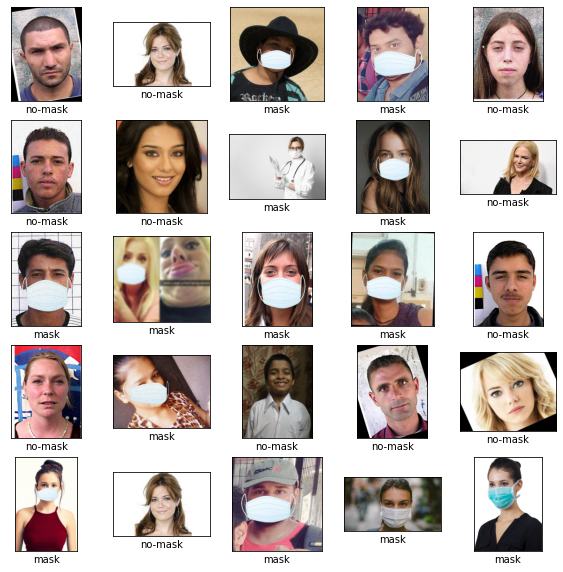

In [10]:
#show the dataset
%matplotlib inline
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(data.gen_dataset().unbatch().take(25)):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.numpy(), cmap=plt.cm.gray)
    plt.xlabel(data.index_to_label[label.numpy()])
plt.show()

Step 2. Customize the TensorFlow model.

In [11]:
#train the model with default tensorflow library
# we train the last layer of the model . 2 dens layer for binary classfication
model = image_classifier.create(train_data,epochs=5,shuffle=True)

INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2 (HubKer (None, 1280)              3413024   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 3,415,586
Trainable params: 2,562
Non-trainable params: 3,413,024
_________________________________________________________________
None
Epoch 1/5
66/66 [==============================] - 103s 1s/step - loss: 0.3574 - accuracy: 0.8877
Epoch 2/5
66/66 [==============================] - 105s 2s/step - loss: 0.2265 - accuracy: 0.9952
Epoch 3/5
66/66 [==============================] - 109s 2s/step - loss: 0.2213 - accuracy: 0.9955
Epoch 4/5
66/66 [==============================] - 98s 1s/step - loss: 0.

Step 3. Evaluate the model.

In [12]:
loss, accuracy = model.evaluate(test_data)

9/9 [==============================] - 24s 1s/step - loss: 0.2115 - accuracy: 1.0000


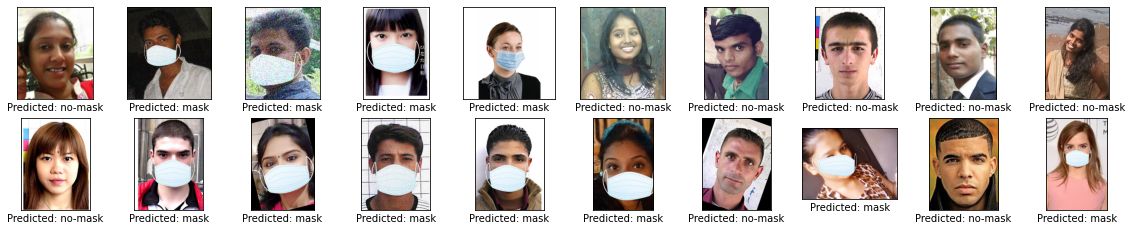

In [14]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
%matplotlib inline

def get_label_color(val1, val2):
    if val1 == val2:
        return 'black'
    else:
        return 'red'

# Then plot 20 test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(20, 20))
predicts = model.predict_top_k(test_data)
for i, (image, label) in enumerate(test_data.gen_dataset().unbatch().take(20)):
    ax = plt.subplot(10, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.numpy(), cmap=plt.cm.gray)

    predict_label = predicts[i][0][0]
    color = get_label_color(predict_label,
                          test_data.index_to_label[label.numpy()])
    ax.xaxis.label.set_color(color)
    plt.xlabel('Predicted: %s' % predict_label)
plt.show()

In [15]:
model2 = image_classifier.create(train_data, model_spec=model_spec.get('mobilenet_v2'), validation_data=validation_data,epochs=4,shuffle=True)

INFO:tensorflow:Retraining the models...


INFO:tensorflow:Retraining the models...


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2_1 (HubK (None, 1280)              2257984   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________
None
Epoch 1/4
66/66 [==============================] - 109s 2s/step - loss: 0.3699 - accuracy: 0.9060 - val_loss: 0.2318 - val_accuracy: 0.9961
Epoch 2/4
66/66 [==============================] - 99s 1s/step - loss: 0.2368 - accuracy: 0.9939 - val_loss: 0.2218 - val_accuracy: 0.9961
Epoch 3/4
66/66 [==============================] - 99s 1s/step - loss: 0.2320 - accura

In [16]:
loss, accuracy = model2.evaluate(test_data)

9/9 [==============================] - 20s 1s/step - loss: 0.2117 - accuracy: 1.0000


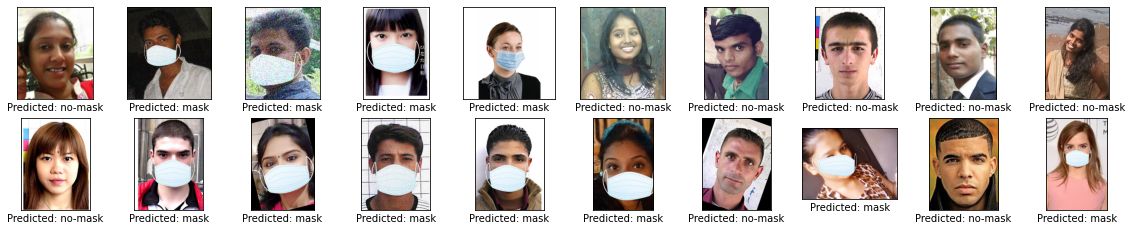

In [17]:
# A helper function that returns 'red'/'black' depending on if its two input
# parameter matches or not.
%matplotlib inline

def get_label_color(val1, val2):
    if val1 == val2:
        return 'black'
    else:
        return 'red'

# Then plot 20 test images and their predicted labels.
# If a prediction result is different from the label provided label in "test"
# dataset, we will highlight it in red color.
plt.figure(figsize=(20, 20))
predicts = model2.predict_top_k(test_data)
for i, (image, label) in enumerate(test_data.gen_dataset().unbatch().take(20)):
    ax = plt.subplot(10, 10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image.numpy(), cmap=plt.cm.gray)

    predict_label = predicts[i][0][0]
    color = get_label_color(predict_label,
                          test_data.index_to_label[label.numpy()])
    ax.xaxis.label.set_color(color)
    plt.xlabel('Predicted: %s' % predict_label)
plt.show()

Step 4.  Export to TensorFlow Lite model.

Here, we export TensorFlow Lite model with [metadata](https://www.tensorflow.org/lite/convert/metadata) which provides a standard for model descriptions. The label file is embedded in metadata.

You could download it in the left sidebar same as the uploading part for your own use.

In [18]:
model.export(export_dir='.',tflite_filename='model-mask-2.tflite',quantization_config=None)

INFO:tensorflow:Assets written to: /var/folders/1j/3qmg1wzs3531dfb_xc4_wx0m0000gn/T/tmps9ju64pi/assets


INFO:tensorflow:Assets written to: /var/folders/1j/3qmg1wzs3531dfb_xc4_wx0m0000gn/T/tmps9ju64pi/assets


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Label file is inside the TFLite model with metadata.


INFO:tensorflow:Saving labels in /var/folders/1j/3qmg1wzs3531dfb_xc4_wx0m0000gn/T/tmpf80ysyqc/labels.txt.


INFO:tensorflow:Saving labels in /var/folders/1j/3qmg1wzs3531dfb_xc4_wx0m0000gn/T/tmpf80ysyqc/labels.txt.


INFO:tensorflow:TensorFlow Lite model exported successfully: ./model-mask-2.tflite


INFO:tensorflow:TensorFlow Lite model exported successfully: ./model-mask-2.tflite


Have a look at the detailed model structure.

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2 (HubKer (None, 1280)              3413024   
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 2)                 2562      
Total params: 3,415,586
Trainable params: 2,562
Non-trainable params: 3,413,024
_________________________________________________________________


In [20]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hub_keras_layer_v1v2_1 (HubK (None, 1280)              2257984   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 2562      
Total params: 2,260,546
Trainable params: 2,562
Non-trainable params: 2,257,984
_________________________________________________________________
